## Random Forest Classifier for News dataset. 



In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix

import math
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime
# Import 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold

In [36]:
import time
import os
import ast
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np

import itertools
import re
import seaborn as sns

import nltk
from nltk.corpus import stopwords

In [37]:
from sklearn.metrics import confusion_matrix, f1_score

In [38]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [39]:
pd.options.display.max_columns
pd.set_option("display.max_columns",100)

### Import data

In [40]:
data = pd.read_csv("https://raw.githubusercontent.com/datajour-gr/iqjournalism/main/sample_data/koinonia_politiki_features_fb.csv")

In [41]:
data.Likes.describe()

count    37551.000000
mean        36.832228
std        159.900171
min          0.000000
25%          4.000000
50%          9.000000
75%         25.000000
max       6260.000000
Name: Likes, dtype: float64

In [42]:
data[data['Likes'] == 0].shape

(1482, 52)

In [43]:
data[data['Likes'] > 150].shape

(1539, 52)

In [44]:
data_good = data[(data.Likes > 150)]

In [45]:
data_good = data_good.dropna()

In [46]:
data_good['engagement'] = 1

In [47]:
data_bad =data[(data.Likes == 0)] #.sample(2767)

In [48]:
data_bad['engagement'] = 0

In [49]:
data = pd.concat([data_good,data_bad], axis=0).reset_index(drop=True)

In [50]:
data.isnull().any()

#title_words            False
Followers at Posting    False
Total Interactions      False
Likes                   False
Comments                False
Shares                  False
Love                    False
Wow                     False
Haha                    False
Sad                     False
Angry                   False
Care                    False
anger                   False
anticipation            False
disgust                 False
fear                    False
joy                     False
negative                False
positive                False
sadness                 False
surprise                False
trust                   False
valence                 False
arousal                 False
dominance               False
strongsubj              False
 weaksubj               False
flesch_reading_ease     False
flesch_kincaid_grade    False
mean_word_length        False
n_stop_words            False
sources                 False
length                  False
MTLD      

In [51]:
data.engagement.describe()

count    3000.000000
mean        0.506000
std         0.500047
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: engagement, dtype: float64

In [52]:
 data.drop(columns=['Total Interactions', 'Comments', 'Shares', 'Love', 'Wow', 'Haha',
  'Sad', 'Angry', 'Care', 'Likes' ], inplace=True)

In [53]:
print(data.corr()["engagement"].abs().sort_values(ascending=False))

engagement              1.000000
Followers at Posting    0.245267
Verbs                   0.221938
Nouns                   0.204931
joy                     0.200075
Sadness_intensity       0.193037
strongsubj              0.185338
sadness                 0.182717
Joy_intensity           0.177461
Adjectives              0.164382
flesch_reading_ease     0.159702
negative                0.157330
disgust                 0.137907
flesch_kincaid_grade    0.129739
surprise                0.122072
trust                   0.121113
positive                0.114126
crime                   0.109639
animal                  0.108567
Fear_intensity          0.101674
mean_word_length        0.098889
fear                    0.098123
anticipation            0.090031
anger                   0.086963
MTLD                    0.080733
No Celebs               0.079176
numbers                 0.075390
Anger_intensity         0.073611
 weaksubj               0.063876
length                  0.060691
special_ch

In [54]:
data.isnull().sum().sum()

100

In [55]:
data= data.dropna()
data.shape

(2975, 43)

In [56]:
data.shape

(2975, 43)

In [57]:
data.columns

Index(['#title_words', 'Followers at Posting', 'anger', 'anticipation',
       'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise',
       'trust', 'valence', 'arousal', 'dominance', 'strongsubj', ' weaksubj',
       'flesch_reading_ease', 'flesch_kincaid_grade', 'mean_word_length',
       'n_stop_words', 'sources', 'length', 'MTLD', 'Nouns', 'Verbs',
       'Adjectives', 'Anger_intensity', 'Joy_intensity', 'Sadness_intensity',
       'Fear_intensity', 'No Celebs', 'animal', 'crime', 'caps_body',
       'numbers', 'urls', 'sensual', 'special_char_ratio', 'strongsubjTitle',
       'WeakSTitle', 'special_char_title', 'engagement'],
      dtype='object')

In [58]:
#data['Subjectivity Title'] = pd.to_numeric(data['Subjectivity Title'], errors='coerce')

In [160]:
data.reset_index(drop=True, inplace=True)

In [97]:
features = ['#title_words', 'anger', 'anticipation',
       'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise',
       'trust', 'valence', 'arousal', 'dominance', 'strongsubj', ' weaksubj',
       'flesch_reading_ease', 'flesch_kincaid_grade', 'mean_word_length',
       'n_stop_words', 'sources', 'length', 'MTLD', 'Nouns', 'Verbs',
       'Adjectives', 'Anger_intensity', 'Joy_intensity', 'Sadness_intensity',
       'Fear_intensity', 'No Celebs', 'animal', 'crime', 'caps_body',
       'numbers', 'urls', 'sensual', 'special_char_ratio', 'strongsubjTitle',
       'WeakSTitle', 'special_char_title',
           ]

In [98]:
data[features].describe()

,#title_words,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,valence,arousal,dominance,strongsubj,weaksubj,flesch_reading_ease,flesch_kincaid_grade,mean_word_length,n_stop_words,sources,length,MTLD,Nouns,Verbs,Adjectives,Anger_intensity,Joy_intensity,Sadness_intensity,Fear_intensity,No Celebs,animal,crime,caps_body,numbers,urls,sensual,special_char_ratio,strongsubjTitle,WeakSTitle,special_char_title
count,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000
mean,12.630588,0.926227,1.192306,0.538283,1.528127,0.804423,2.056972,2.726745,1.163583,0.571419,1.786356,1.771330,0.472289,0.550943,2.223256,24.699947,18.742772,16.342817,5.052470,194.207731,0.208403,415.187899,106.864568,25.061352,10.958579,8.270989,0.099473,0.126143,0.110829,0.144190,0.216807,0.158655,0.602017,0.140840,3.871261,0.082689,0.181849,4.500636,1.234854,1.086372,0.779971
std,3.711114,1.115772,1.084705,0.783459,1.418717,0.950823,1.692333,1.686186,1.250438,0.758297,1.368120,19.947562,0.105812,0.100910,1.587829,16.298568,16.133348,3.773467,0.373306,220.781544,0.542352,459.269364,20.652845,4.479863,3.268496,2.817875,0.070433,0.075168,0.075934,0.085948,0.721735,0.667004,1.457166,0.817592,9.389926,0.559102,0.626317,5.068379,3.091890,2.942806,0.856332
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.155308,0.188622,0.270652,0.000000,0.000000,-131.105696,5.363987,3.794613,14.000000,0.000000,60.000000,59.000000,9.770115,0.593952,1.030928,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,0.398208,0.000000,0.503782,0.000000,0.833333,1.538462,0.000000,0.000000,0.817999,0.497547,0.395708,0.478371,1.086957,12.987013,8.950597,13.725559,4.820061,71.000000,0.000000,157.500000,93.000000,21.965318,8.750000,6.270217,0.048545,0.074185,0.054864,0.081415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.686578,0.000000,0.000000,0.187970
50%,13.000000,0.621118,1.020408,0.160256,1.265823,0.588235,1.731602,2.564103,0.854701,0.326797,1.554404,0.584604,0.463578,0.547130,2.027027,23.148148,19.514286,15.952044,5.042506,125.000000,0.000000,275.000000,109.166667,24.806202,10.818713,7.981221,0.086333,0.111115,0.098179,0.133439,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,3.768624,0.000000,0.000000,0.572519
75%,15.000000,1.428571,1.739130,0.840336,2.209945,1.214575,2.919708,3.674407,1.716738,0.900901,2.549396,0.662610,0.537897,0.623440,3.157020,34.374108,29.644781,18.658726,5.268466,233.000000,0.000000,490.000000,121.666667,27.831942,13.142857,9.929813,0.139165,0.166770,0.154759,0.194243,0.000000,0.000000,1.000000,0.000000,4.000000,0.000000,0.000000,6.099628,0.000000,0.000000,1.075269
max,26.000000,15.384615,9.722222,8.461538,17.692308,8.130081,17.692308,12.500000,15.384615,5.084746,8.771930,500.352439,0.855009,0.865660,13.483146,200.000000,70.550027,37.636703,8.951792,4191.000000,6.000000,9208.000000,308.666667,46.354167,23.076923,19.791667,0.557333,0.636250,0.532875,0.551200,11.000000,12.000000,16.000000,18.000000,141.000000,18.000000,12.000000,115.277778,25.641026,21.276596,8.860759


In [99]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

In [100]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [101]:
data[data==np.inf]=np.nan
data.fillna(data.mean(), inplace=True)

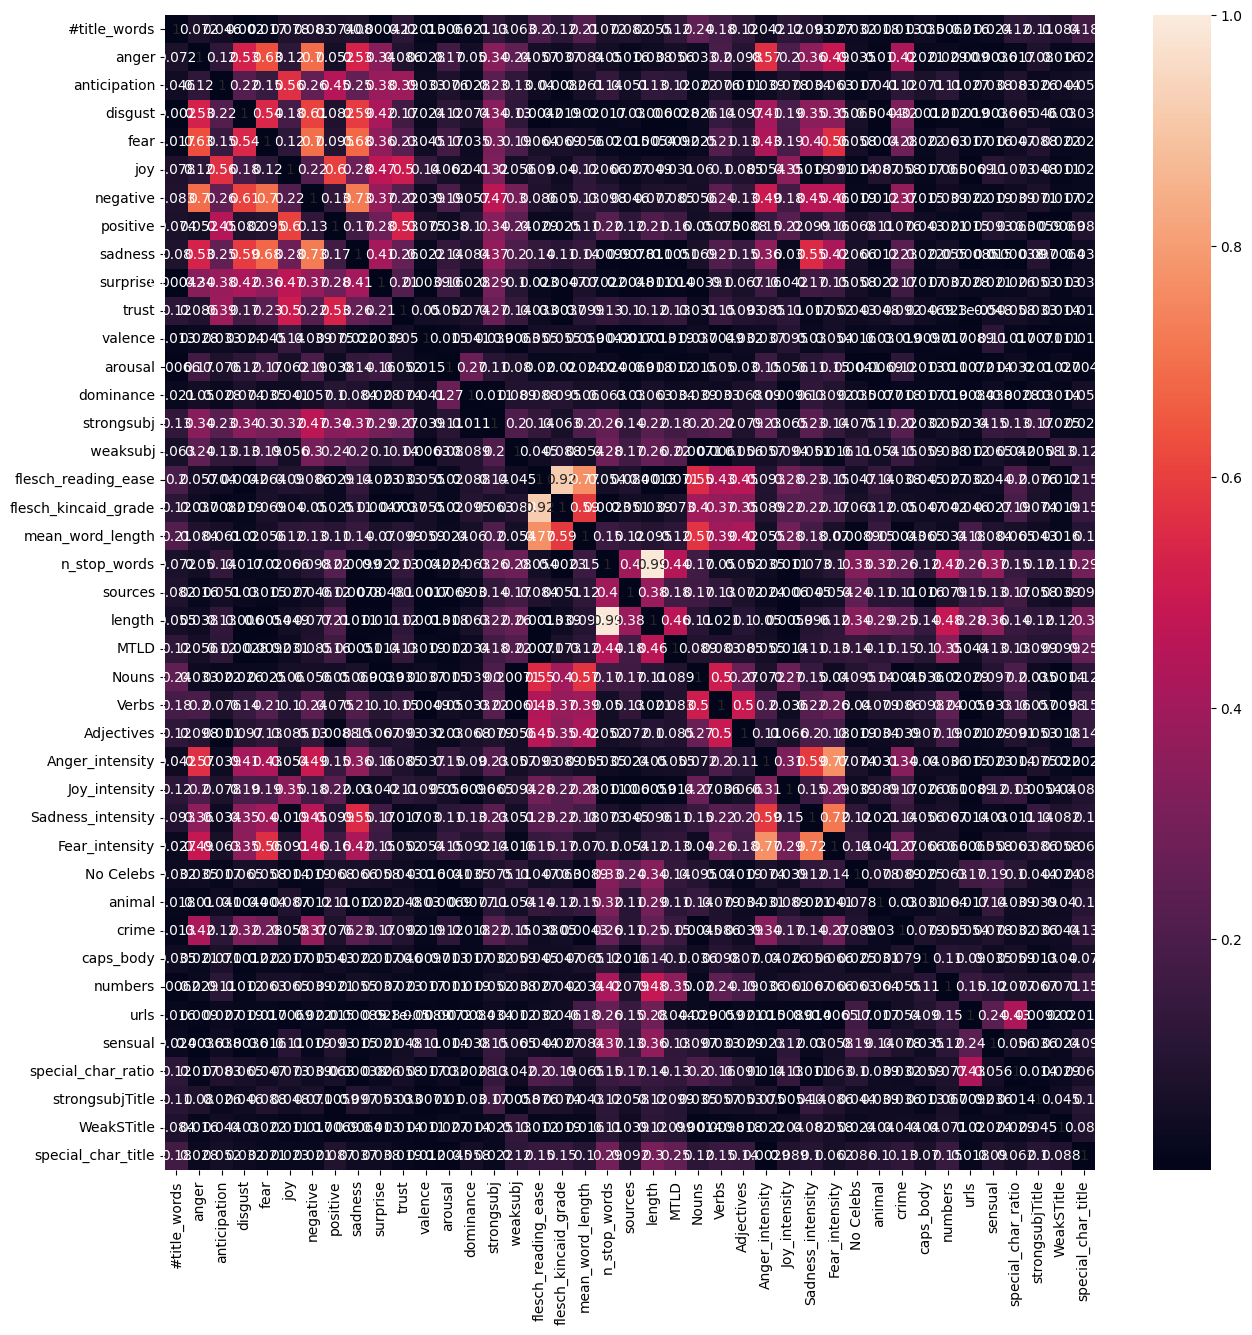

In [102]:
import math
import matplotlib.pyplot as plt
%matplotlib inline 

correlationMatrix = data[features].corr().abs()

plt.subplots(figsize=(15, 15))
sns.heatmap(correlationMatrix,annot=True)

# Mask unimportant features
sns.heatmap(correlationMatrix, mask=correlationMatrix < 1, cbar=False)
plt.show()

# Model construction starts here

In [103]:
data.head()

,#title_words,Followers at Posting,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,valence,arousal,dominance,strongsubj,weaksubj,flesch_reading_ease,flesch_kincaid_grade,mean_word_length,n_stop_words,sources,length,MTLD,Nouns,Verbs,Adjectives,Anger_intensity,Joy_intensity,Sadness_intensity,Fear_intensity,No Celebs,animal,crime,caps_body,numbers,urls,sensual,special_char_ratio,strongsubjTitle,WeakSTitle,special_char_title,engagement
0,6,170556.0,0.511945,0.511945,0.170648,0.853242,0.170648,2.559727,1.877133,0.000000,0.341297,1.365188,0.474719,0.516889,0.533635,2.218430,18.771331,3.641021,19.799731,5.222513,457.0,0,995,124.375000,25.427136,10.653266,10.050251,0.041093,0.069785,0.056617,0.055888,0,0,1,0,8,0,0,6.996587,0.000000,0.0,0.00000,1
1,6,170556.0,1.200000,0.800000,0.400000,2.400000,0.400000,3.200000,1.600000,2.000000,0.800000,1.200000,0.627245,0.540726,0.689485,2.000000,32.000000,24.348645,15.344120,4.849754,164.0,0,352,117.333333,25.852273,10.795455,7.954545,0.067444,0.161852,0.087667,0.127315,0,0,0,0,6,0,0,3.600000,4.000000,0.0,0.00000,1
2,14,170540.0,0.558659,2.793296,0.279330,2.513966,1.955307,3.910615,5.307263,2.513966,1.117318,3.351955,0.569682,0.371632,0.439666,2.793296,39.106145,22.279759,15.062339,4.948640,296.0,0,589,117.800000,22.580645,14.601019,7.979626,0.078829,0.136868,0.135632,0.155829,0,1,0,0,1,0,0,1.675978,2.793296,0.0,0.27933,1
3,0,170596.0,0.694444,0.000000,0.000000,0.000000,0.000000,2.777778,2.083333,0.000000,0.000000,0.694444,0.580643,0.512914,0.740176,0.000000,48.611111,-24.745662,28.324853,5.485577,82.0,0,187,93.500000,35.294118,5.882353,11.764706,0.003906,0.094219,0.113969,0.127188,0,0,0,0,0,0,0,1.388889,0.000000,0.0,0.00000,1
4,7,170659.0,1.129944,2.259887,0.282486,1.412429,1.129944,4.802260,2.824859,2.824859,0.000000,2.259887,0.341099,0.479391,0.401470,4.237288,33.898305,28.241391,15.253824,4.770000,338.0,1,625,125.000000,22.400000,12.640000,7.200000,0.107593,0.132284,0.185469,0.158210,0,0,4,0,0,0,0,5.367232,0.000000,0.0,0.00000,1


In [104]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.dtypes

#title_words              int64
Followers at Posting    float64
anger                   float64
anticipation            float64
disgust                 float64
fear                    float64
joy                     float64
negative                float64
positive                float64
sadness                 float64
surprise                float64
trust                   float64
valence                 float64
arousal                 float64
dominance               float64
strongsubj              float64
 weaksubj               float64
flesch_reading_ease     float64
flesch_kincaid_grade    float64
mean_word_length        float64
n_stop_words            float64
sources                   int64
length                    int64
MTLD                    float64
Nouns                   float64
Verbs                   float64
Adjectives              float64
Anger_intensity         float64
Joy_intensity           float64
Sadness_intensity       float64
Fear_intensity          float64
No Celeb

In [105]:
X = data[features]
y = data['engagement']

In [106]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=10)

In [107]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2380, 41), (595, 41), (2380,), (595,))

# Logistic Regression

In [108]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train,y_train)

Y_pred_lr = lr.predict(X_val)

In [109]:
score_lr = round(accuracy_score(Y_pred_lr,y_val)*100,2)

print("The accuracy score achieved using Logistic Regression is: "+str(score_lr)+" %")

The accuracy score achieved using Logistic Regression is: 63.03 %


In [110]:
#f1_score(y_val, Y_pred_lr, average='weighted')

In [111]:
print('Classification Report\n', classification_report(y_val, Y_pred_lr))

Classification Report
               precision    recall  f1-score   support

           0       0.59      0.62      0.61       273
           1       0.66      0.64      0.65       322

    accuracy                           0.63       595
   macro avg       0.63      0.63      0.63       595
weighted avg       0.63      0.63      0.63       595



In [112]:
# Import 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Ξεκινήστε τη λίστα βαθμολογίας μοντέλου
model_score = []
# Δημιουργήστε μια λίστα με τις πραγματικές τιμές
true_labels = []
# Δημιουργήστε τη λίστα των προβλεπόμενων τιμών
predicted_labels = []
# Ορίστε το αντικείμενο σταυροειδούς επαλήθευσης (cv)
our_cv = RepeatedKFold(n_splits=10, n_repeats=10)
# Ορίστε το Logistic Regression 
log_reg = LogisticRegression(penalty='none', random_state=123, solver='saga', max_iter = 10000, warm_start=True)
# Λούπα που παράχθηκε από τα κοψίματα του cv
for i_train, i_test in our_cv.split(X):
    # Ορίστε τα σετς
    X_train, X_val, y_train, y_val = X.iloc[i_train], X.iloc[i_test], y.iloc[i_train], y.iloc[i_test]
    # Fitting του logistic regression
    log_reg.fit(X_train, y_train.astype('int'))
#    importances = pd.DataFrame(data={
#    'Attribute': X_train.columns,
#    'Importance': model.coef_[0]
#    })
#    importances = importances.sort_values(by='Importance', ascending=False)
    # Πρόβλεψη των δεδομένων του testing σετ
    y_pred_test = log_reg.predict(X_val)
    # Λήψη βαθμολογίας ακρίβειας
    model_score.append(accuracy_score(y_val.astype('int'), y_pred_test.astype('int')))
    # Προσθέστε τις αληθινές τιμές στη λίστα
    true_labels.extend(y_val.astype('int'))
    # Προσθέστε τις προβλεπόμενες τιμές στη λίστα
    predicted_labels.extend(y_pred_test.astype('int'))

In [113]:
#Υπολογίστε τη μέση ακρίβεια κατά την 10 x 10 σταυροειδή επαλήθευση
# Χρήση του μέσου όρου για 100 τιμές μέσα στο model_score
print("Η μέση ακρίβεια του μοντέλου λογιστικής παλινδρόμησης είναι: "+str(np.mean(model_score))+" %")

Η μέση ακρίβεια του μοντέλου λογιστικής παλινδρόμησης είναι: 0.6556599552572707 %


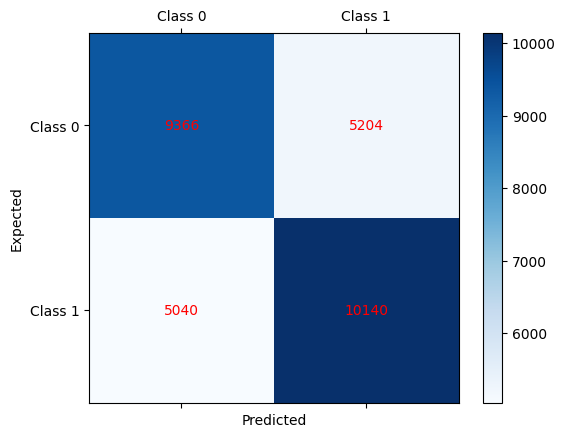

In [114]:
from sklearn.metrics import confusion_matrix
# Υπολογισμός 
conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
# Ορισμός των labels 
labels = ['Class 0', 'Class 1']
# Ξεκινήστε ένα άδειο σχήμα
fig = plt.figure()
# Προσθέστε άξονα στο σχήμα
ax = fig.add_subplot(111)
# Προσθέστε τον πίνακα
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
# Εμφάνιση γραμμής χρωμάτων
fig.colorbar(cax)
# Αφαίρεση των x και y ticks
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
# Προσθέστε τα labels x και y
plt.xlabel('Predicted')
plt.ylabel('Expected')
# Προσθέστε νέα x και y ticks
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='r')
# Τυπώστε τον πίνακα
plt.show()

In [115]:
model = LogisticRegression()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

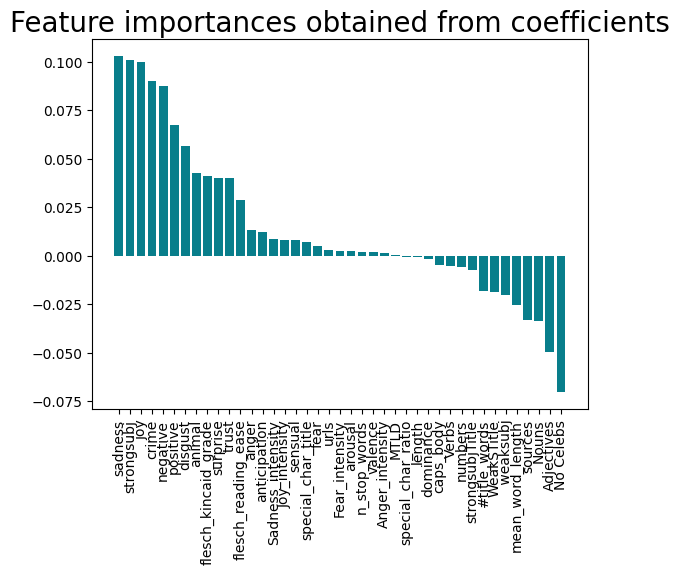

In [116]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

# SVM

In [ ]:
from sklearn import svm

sv = svm.SVC(kernel='linear')

sv.fit(X_train, y_train)

Y_pred_svm = sv.predict(X_val)

In [182]:
f1_score(y_val, Y_pred_svm, average='weighted')

0.7375303257161838

# Study the Decision Tree Classifier

In [117]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import RepeatedKFold

In [118]:
estimator = DecisionTreeClassifier(criterion='gini', splitter='best', 
max_depth=8, min_samples_split=500, min_samples_leaf=500, 
min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, 
 class_weight=None, ccp_alpha=0.0)

In [119]:
estimator.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=500, min_samples_split=500)

In [120]:
val_pred_probs = estimator.predict_proba(X_val)

val_pred = estimator.predict(X_val)

In [121]:
f1_score(y_val, val_pred, average='macro')

0.558641975308642

In [122]:
leave_id = estimator.apply(X_val)
print("The number of nodes is ", estimator.tree_.node_count)

The number of nodes is  7


In [123]:
dataplus = pd.concat([X_val.reset_index(),y_val.reset_index(),pd.DataFrame(val_pred_probs, columns=['prob0', 'prob1'])['prob1'], pd.DataFrame(leave_id, columns=['node'])], axis = 1) #.columns =['prob', 'node']

In [124]:
dataplus.shape

(297, 46)

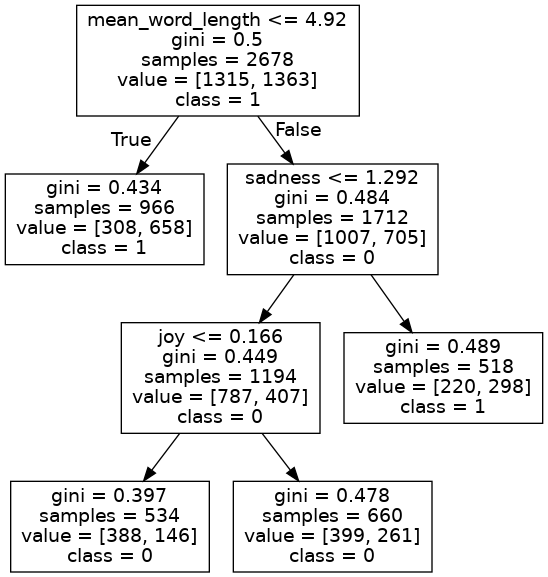

In [125]:
from graphviz import Source
from sklearn import tree
graph = Source( tree.export_graphviz(estimator, out_file=None, feature_names=X.columns, class_names=["0", "1"]))
png_bytes = graph.pipe(format='png')
with open('tree_pipe4.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

# Study now the Random Forest Classifier

In [126]:
rf = RandomForestClassifier()

In [127]:
#Get the best RF Classifier from the grid

In [128]:
rf = RandomForestClassifier()
grid = {'min_samples_leaf' : [15, 20], 
        'min_samples_split' : [   40, 60], 
       }
clf = GridSearchCV(rf, grid, cv=5)
clf.fit(X_train, y_train)
#best_clf = clf.best_estimator_

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [15, 20],
                         'min_samples_split': [40, 60]})

In [129]:
clf_val_pred_probs = clf.predict_proba(X_val)

clf_val_pred = clf.predict(X_val)

In [130]:
# Get the f1 Score of the best RF classifier of the grid

f1_score(y_val, clf_val_pred, average='macro')

0.648936170212766

In [131]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [132]:
print(classification_report(y_val, clf_val_pred))

              precision    recall  f1-score   support

           0       0.64      0.63      0.63       142
           1       0.66      0.67      0.67       155

    accuracy                           0.65       297
   macro avg       0.65      0.65      0.65       297
weighted avg       0.65      0.65      0.65       297



# Lets Try a RF classifier selecting manually the parameters

In [133]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=20, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rf.fit(X_train, y_train)

val_pred_probs = rf.predict_proba(X_val)

val_pred = rf.predict(X_val)

In [134]:
train_pred_probs = rf.predict_proba(X_train)
train_pred = rf.predict(X_train)


In [135]:
log_loss(y_val, val_pred_probs, labels=rf.classes_)

0.6457856874692647

In [136]:
log_loss(y_train, train_pred_probs, labels=rf.classes_)

0.49723097054382204

In [137]:
f1_score(y_val, val_pred, average='macro')

0.6480721903199345

In [138]:
fi = pd.DataFrame(rf.feature_importances_, X_train.columns)
fi.columns = ['Importance']
fi.sort_values(by = 'Importance', ascending=False)[0:20]

,Importance
mean_word_length,0.091232
flesch_reading_ease,0.071071
Sadness_intensity,0.068117
Joy_intensity,0.055360
joy,0.050164
sadness,0.044769
Nouns,0.041470
Adjectives,0.037137
Verbs,0.035484
strongsubj,0.034756


In [139]:
f1_score(y_val, val_pred, average='macro')

0.6480721903199345

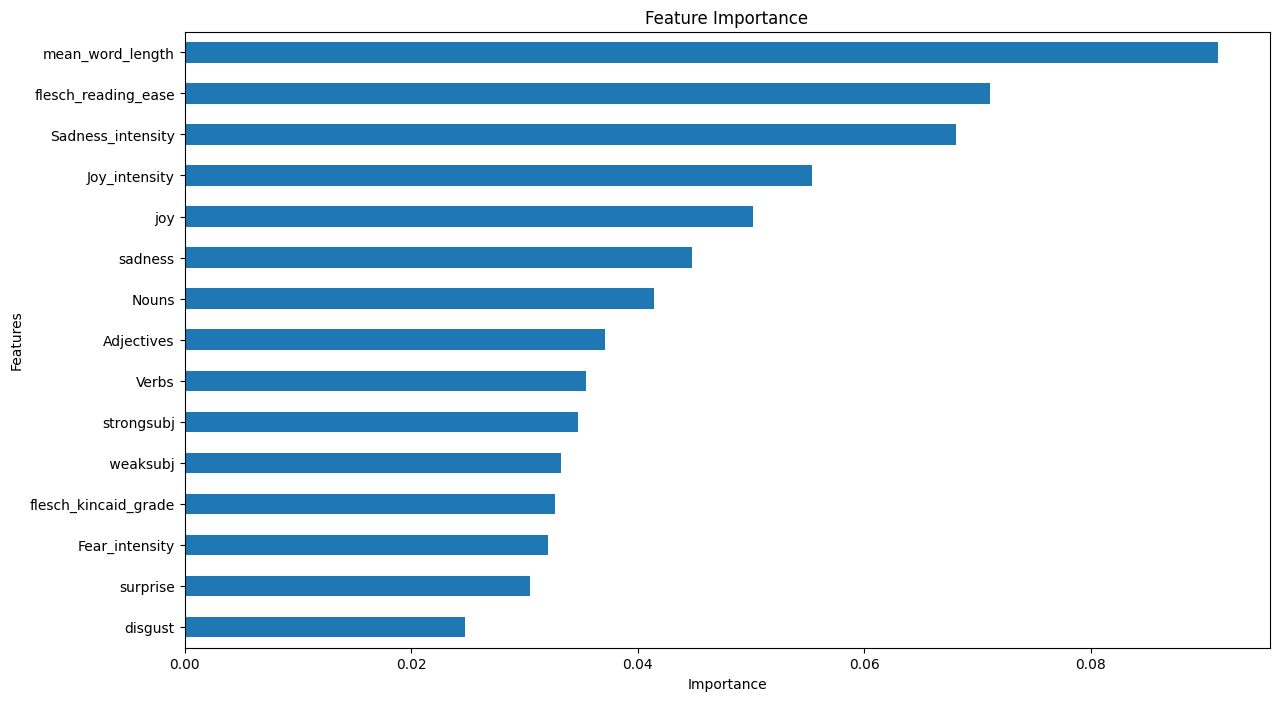

In [140]:
import matplotlib.pyplot as plt

plot = fi.sort_values(by = 'Importance', ascending=True).tail(15).plot.barh(figsize = (14,8), legend = False, title = 'Feature Importance', 
                                                                           )

#plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

fig = plot.get_figure()
#fig.savefig('Importance_News_75.png')



In [141]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Automatically created module for IPython interactive environment


Confusion matrix, without normalization
[[ 86  56]
 [ 48 107]]


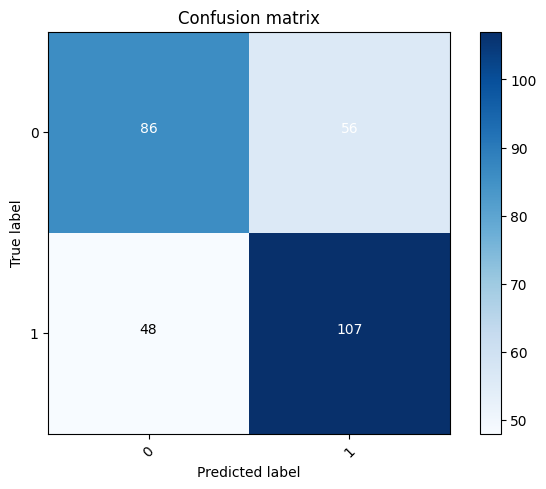

In [142]:
# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_train, train_pred)

cnf_matrix = confusion_matrix(y_val, val_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rf.classes_,
                      title='Confusion matrix')


In [143]:
# Check AGAIN the accurance of the manually defined RF classifier

f1_score(y_val, val_pred, average='macro')

0.6480721903199345

In [144]:
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       0.64      0.61      0.62       142
           1       0.66      0.69      0.67       155

    accuracy                           0.65       297
   macro avg       0.65      0.65      0.65       297
weighted avg       0.65      0.65      0.65       297



In [145]:
n_nodes = []
max_depths = []

for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Total number of Trees {int(len(rf.estimators_))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


Total number of Trees 2000
Average number of nodes 128
Average maximum depth 11


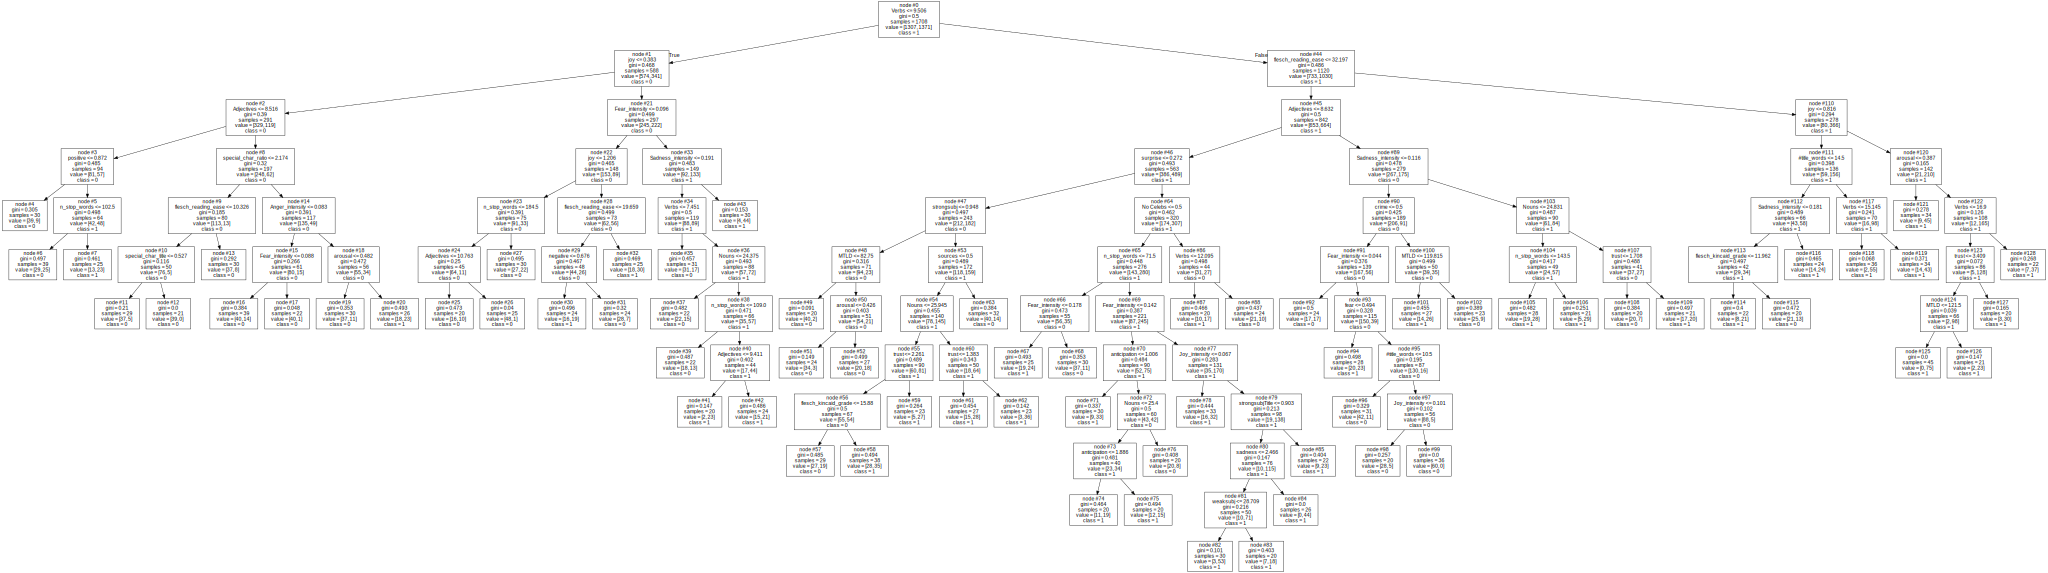

In [146]:
# visualizing the nth tree of the Random Forest (n=0)
import graphviz
from sklearn.tree import export_graphviz

#dot_data = export_graphviz(rf.estimators_[0])
graphviz.Source(export_graphviz(rf.estimators_[10],
                                out_file=None,
                                feature_names=features,
                                class_names=["0", "1"],
                                node_ids = True,
                                impurity=True))

In [147]:
MAX_ROUNDS = 180
OPTIMIZE_ROUNDS = True
LEARNING_RATE = 0.1
EARLY_STOPPING_ROUNDS = 55  
# Note: I set EARLY_STOPPING_ROUNDS high so that (when OPTIMIZE_ROUNDS is set)
#       I will get lots of information to make my own judgment.  You should probably
#       reduce EARLY_STOPPING_ROUNDS if you want to do actual early stopping.

In [148]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
#from numba import jit
import time
import gc

In [149]:
# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
#@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]



In [150]:
# Set up classifier
model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=8,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

In [151]:
fit_model_xgb = model.fit(X_train,y_train)

In [152]:
val_pred_xgb = fit_model_xgb.predict(X_val)

Confusion matrix, without normalization
[[ 47 105]
 [ 19 199]]


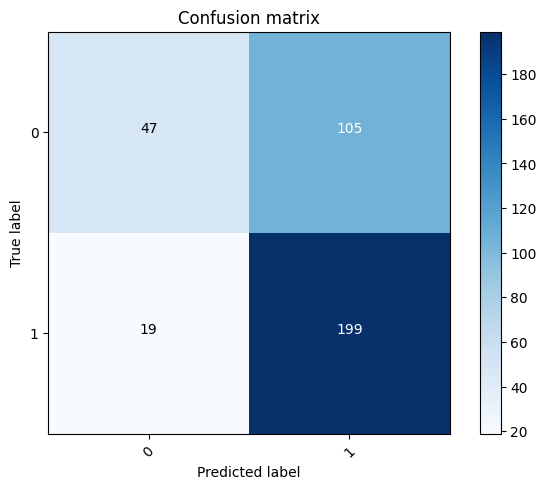

In [109]:
# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_train, train_pred)

cnf_matrix = confusion_matrix(y_val, val_pred_xgb)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rf.classes_,
                      title='Confusion matrix')


In [110]:
f1_score(y_val, val_pred_xgb, average='macro')

0.5968223839150761

In [111]:
print(classification_report(y_val, val_pred_xgb))

              precision    recall  f1-score   support

           0       0.71      0.31      0.43       152
           1       0.65      0.91      0.76       218

    accuracy                           0.66       370
   macro avg       0.68      0.61      0.60       370
weighted avg       0.68      0.66      0.63       370



In [112]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_val, val_pred_xgb))


Accuracy :  0.6648648648648648


In [153]:
import eli5

2024-02-16 01:53:07.442997: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 01:53:09.142658: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 01:53:09.175480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 01:53:12.504568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [154]:
eli5.show_prediction(rf, X_val[features].iloc[0], show_feature_values=True)

In [155]:
eli5.show_prediction(rf, X_val[features].iloc[1], show_feature_values=True)

In [116]:
eli5.explain_prediction(rf, data[features].iloc[1])

Explanation(estimator='RandomForestClassifier(min_samples_leaf=20, min_samples_split=40,\n                       n_estimators=2000, n_jobs=1)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.6055579688436189, std=None, value=1.0), FeatureWeight(feature='Joy_intensity', weight=0.057908288040031126, std=None, value=0.1827631578947368), FeatureWeight(feature='No Celebs', weight=0.051957941844895814, std=None, value=1.0), FeatureWeight(feature='Nouns', weight=0.0362797674026838, std=None, value=35.064935064935064), FeatureWeight(feature='valence', weight=0.024338787133572022, std=None, value=0.824813332432881), FeatureWeight(feature='flesch_reading_ease', weight=0.02237036944265917, std=None, value=35.080238450074546), FeatureWeight(feature='numbers', weight=0.01244812436701666, std=None, value=7.0), FeatureWeight(feature='Verbs', weight=0.012351137383705585, std=None, value=18.181818181818183), FeatureWeight(feature='MTLD', weight=0.0058480727178628214, std=None, value=121.0), FeatureWeight(feature='anger', weight=0.005093102831846892, std=None, value=0.847457627118644), FeatureWeight(feature='anticipation', weight=0.004757538807811758, std=None, value=2.5423728813559325), FeatureWeight(feature='trust', weight=0.00359430335113236, std=None, value=0.847457627118644), FeatureWeight(feature='Fear_intensity', weight=0.0033061812648860433, std=None, value=0.1200263157894736), FeatureWeight(feature='surprise', weight=0.0030349375511765225, std=None, value=0.847457627118644), FeatureWeight(feature='Sadness_intensity', weight=0.002759036395976239, std=None, value=0.0673157894736842), FeatureWeight(feature='dominance', weight=0.0016348649155885795, std=None, value=0.6519417858868837), FeatureWeight(feature='crime', weight=0.0014163032813935565, std=None, value=0.0), FeatureWeight(feature='positive', weight=0.001074994611322627, std=None, value=3.389830508474576), FeatureWeight(feature='disgust', weight=0.0005925469241240501, std=None, value=0.0), FeatureWeight(feature='strongsubj', weight=0.0005550348404093168, std=None, value=6.0), FeatureWeight(feature='animal', weight=5.684652113013666e-06, std=None, value=0.0)], neg=[FeatureWeight(feature='length', weight=-0.029238576447498204, std=None, value=154.0), FeatureWeight(feature='Anger_intensity', weight=-0.01677149361965289, std=None, value=0.169578947368421), FeatureWeight(feature='arousal', weight=-0.006449419647019828, std=None, value=0.4517020455822348), FeatureWeight(feature='Adjectives', weight=-0.0048787372527641, std=None, value=18.83116883116883), FeatureWeight(feature='negative', weight=-0.004083539334551591, std=None, value=3.389830508474576), FeatureWeight(feature='sadness', weight=-0.0036847583944107838, std=None, value=0.0), FeatureWeight(feature='caps_body